In [2]:
from music21 import *

In [20]:
def read_midi(file):
    print('Loading Music File:', file)
    
    notes=[]
    notes_to_parse = None
    
    midi = converter.parse(file)
    s2 = instrument.partitionByInstrument(midi)
    
    for part in s2.parts:
        if 'Piano' in str(part):
            notes_to_parse = part.recurse()
            
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                    
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
                    
    return np.array(notes)

In [21]:
import os
import numpy as np

path='schubert/'

files=[i for i in os.listdir(path) if i.endswith('.mid')]
notes_array = np.array([read_midi(path+i) for i in files]) 

Loading Music File: schubert/schubert_D850_1.mid
Loading Music File: schubert/schubert_D850_2.mid
Loading Music File: schubert/schubert_D850_3.mid
Loading Music File: schubert/schubert_D850_4.mid
Loading Music File: schubert/schubert_D935_1.mid
Loading Music File: schubert/schubert_D935_2.mid
Loading Music File: schubert/schubert_D935_3.mid
Loading Music File: schubert/schubert_D935_4.mid
Loading Music File: schubert/schub_d760_1.mid
Loading Music File: schubert/schub_d760_2.mid
Loading Music File: schubert/schub_d760_3.mid
Loading Music File: schubert/schub_d760_4.mid
Loading Music File: schubert/schub_d960_1.mid
Loading Music File: schubert/schub_d960_2.mid
Loading Music File: schubert/schub_d960_3.mid
Loading Music File: schubert/schub_d960_4.mid
Loading Music File: schubert/schuim-1.mid
Loading Music File: schubert/schuim-2.mid
Loading Music File: schubert/schuim-3.mid
Loading Music File: schubert/schuim-4.mid
Loading Music File: schubert/schumm-1.mid
Loading Music File: schubert/s

In [22]:
notes_ = [element for note_ in notes_array for element in note_]

unique_notes = list(set(notes_))
print(len(unique_notes))

304


(array([187.,  41.,  26.,  11.,   6.,   9.,  12.,   6.,   3.,   3.]),
 array([1.0000e+00, 1.4790e+02, 2.9480e+02, 4.4170e+02, 5.8860e+02,
        7.3550e+02, 8.8240e+02, 1.0293e+03, 1.1762e+03, 1.3231e+03,
        1.4700e+03]),
 <a list of 10 Patch objects>)

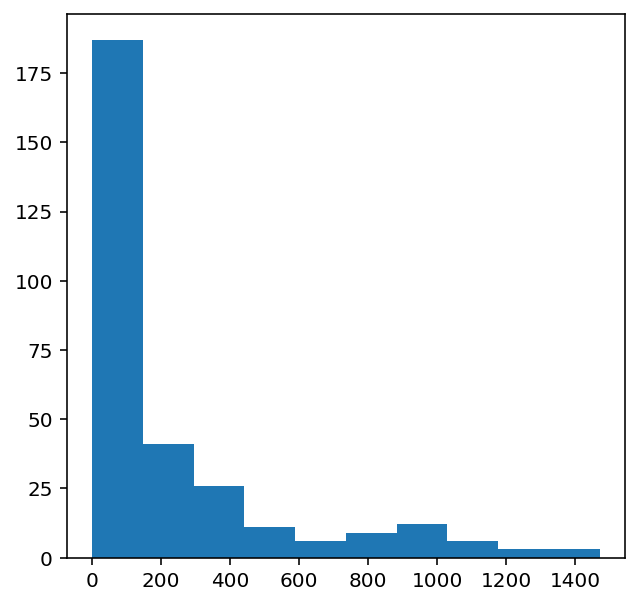

In [23]:
from collections import Counter

freq = dict(Counter(notes_))

import matplotlib.pyplot as plt

no=[count for _, count in freq.items()]
plt.figure(figsize=(5,5))

plt.hist(no)

In [24]:
frequency_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequency_notes))

167


In [25]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequency_notes:
            temp.append(note_)
    new_music.append(temp)
    
new_music = np.array(new_music)

In [27]:
no_of_timestamps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timestamps, 1):
        input_ = note_[i:i + no_of_timestamps]
        output = note_[i + no_of_timestamps]
        
        x.append(input_)
        y.append(output)

x=np.array(x)
y=np.array(y)

In [29]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_,number) for number, note_ in enumerate(unique_x)) 

In [30]:
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [31]:
unique_y = list(set(y))
y_note_to_int = dict((note_,number) for number, note_ in enumerate(unique_y))
y_seq = np.array([y_note_to_int[i] for i in y])

In [32]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq, y_seq, test_size=0.2, random_state=0)

In [33]:
def lstm():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model 

In [34]:
from keras.layers import * 
from keras.models import *
from keras.callbacks import *
import keras.backend as k

k.clear_session()
model = Sequential()

model.add(Embedding(len(unique_x), 100, input_length=32, trainable=True))

model.add(Conv1D(64, 3, padding='causal', activation='relu')) 
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(128, 3, activation='relu', dilation_rate=2, padding='causal')) 
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256, 3, activation='relu', dilation_rate=4, padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
model.add(GlobalMaxPool1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           16700     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            19264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_2 (Dropout)  

In [36]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [37]:
history=model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50,validation_data=(np.array(x_val),
                np.array(y_val)),verbose=1, callbacks=[mc])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 51530 samples, validate on 12883 samples
Epoch 1/50
51530/51530 [==============================] - 20s 386us/step - loss: 4.3129 - val_loss: 4.0313

Epoch 00001: val_loss improved from inf to 4.03131, saving model to best_model.h5
Epoch 2/50
51530/51530 [==============================] - 19s 372us/step - loss: 3.7858 - val_loss: 3.7875

Epoch 00002: val_loss improved from 4.03131 to 3.78752, saving model to best_model.h5
Epoch 3/50
51530/51530 [==============================] - 22s 428us/step - loss: 3.6156 - val_loss: 3.7285

Epoch 00003: val_loss improved from 3.78752 to 3.72846, saving model to best_model.h5
Epoch 4/50
51530/51530 [==============================] - 22s 428us/step - loss: 3.4887 - val_loss: 3.5899

Epoch 00004: val_loss improved from 3.72846 to 3.58995, saving model to best_model.h5
Epoch 5/50
51530/51530 [============================

51530/51530 [==============================] - 23s 453us/step - loss: 2.3918 - val_loss: 2.8125

Epoch 00040: val_loss improved from 2.82101 to 2.81253, saving model to best_model.h5
Epoch 41/50
51530/51530 [==============================] - 23s 454us/step - loss: 2.3955 - val_loss: 2.8144

Epoch 00041: val_loss did not improve from 2.81253
Epoch 42/50
51530/51530 [==============================] - 23s 455us/step - loss: 2.3826 - val_loss: 2.8199

Epoch 00042: val_loss did not improve from 2.81253
Epoch 43/50
51530/51530 [==============================] - 24s 458us/step - loss: 2.3705 - val_loss: 2.8128

Epoch 00043: val_loss did not improve from 2.81253
Epoch 44/50
51530/51530 [==============================] - 24s 473us/step - loss: 2.3659 - val_loss: 2.8034

Epoch 00044: val_loss improved from 2.81253 to 2.80343, saving model to best_model.h5
Epoch 45/50
51530/51530 [==============================] - 23s 446us/step - loss: 2.3540 - val_loss: 2.7879

Epoch 00045: val_loss improved fr

In [38]:
from keras.models import load_model
model = load_model('best_model.h5')

In [41]:
import random 

ind = np.random.randint(0,len(x_val)-1)
random_music = x_val[ind]

predictions=[]
for i in range(10):
    random_music = random_music.reshape(1,no_of_timestamps)
    
    prob = model.predict(random_music)[0]
    y_pred = np.argmax(prob, axis=0)
    predictions.append(y_pred)
    
    random_music = np.insert(random_music[0], len(random_music[0]), y_pred)
    random_music = random_music[1:]
    
print(predictions)

[17, 17, 17, 133, 17, 17, 17, 17, 17, 17]


In [42]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [43]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [44]:
convert_to_midi(predicted_notes)